In [43]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import sys

from pygments.styles.dracula import background

sys.path.append(r'C:\Users\acostamendoza\projects\Grid-orientation-project\src')
from GridMetrics import GridScorer, circle_mask, get_even_odd_times, GridParameters, create_new_result_dir, load_grid_metrics_from_pickle
import json
import random
import scipy
from skimage.feature import peak_local_max
from scipy.stats import linregress
%load_ext autoreload
%autoreload 2

# Set default parameters for matplotlib
plt.rcParams.update({
    'xtick.major.size': 8,
    'ytick.major.size': 8,
    'xtick.labelsize': 14,
    'ytick.labelsize': 14, 
    'axes.titlesize': 16,
    'legend.fontsize': 12,
})

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [101]:
rat = 'r1'
mod = '2'
fig_directory  = r'C:\Users\acostamendoza\Box\grid-cell-project\review-width-vs-variability'

In [102]:
G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)
    
with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
    cell_trial_dict = json.load(f)

Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12 already exists


# Get between variability

In [103]:
def get_cell_width(cell, plot=False):
    
    interp = G.Scorer.get_sac_interp(cell)
    spacing_vec = np.linspace(0, 1, 200)

    spacing_values = []
    for r in spacing_vec:
        value = interp(np.array([0, r]).T)[0]
        spacing_values.append(value)

    spacing_values = np.array(spacing_values)
    spacing_peaks, _ = scipy.signal.find_peaks(-1 * spacing_values)

    cell_width = spacing_vec[spacing_peaks][0]
    
    if plot:
        
        fig, axs = plt.subplots(1, 2, figsize=(10, 6))
        fig.suptitle('Best Cell: {}, Grid Score = {:.2f}'.format(cell, G.grid_scores[cell]), fontsize=22)

        ax = axs[1]
        sac = G.Scorer.calculate_sac(cell)
        
        # make a circle of radius cell_width around the center of the sac
        circle = plt.Circle((sac.shape[0] // 2, sac.shape[1] // 2), cell_width * sac.shape[0]//4, color='black', fill=False)
        ax.add_artist(circle)
        
        cmap = matplotlib.colormaps['viridis']
        cmap.set_bad(color='white')

        ax.imshow(sac, cmap=cmap)
        ax.set_aspect('equal', 'box')
        ax.axis('off')
        ax.set_title('Masked SAC', fontsize=18)

        ax = axs[0]
        ax.plot(spacing_vec, spacing_values, linewidth=2)
        ax.scatter(spacing_vec[spacing_peaks], spacing_values[spacing_peaks], color='r')
        ax.scatter(spacing_vec[spacing_peaks][0], spacing_values[spacing_peaks][0], color='g')
        ax.set_xlabel('Radius', fontsize=16)
        ax.set_ylabel('SAC Value', fontsize=16)
        # set axis square
        ax.set_aspect('equal', 'box')
        ax.set_title('SAC Value in radial direction', fontsize=18)
        # Remove top and right splines
        ax.spines['top'].set_visible(False)
        ax.spines['right'].set_visible(False)
        # set ticks of fontsize 12
        ax.tick_params(axis='both', which='major', labelsize=12)
        
    return cell_width

In [104]:
def show_width_of_field(cell):
    
    ratemap = G.Scorer.calculate_ratemap(cell = cell)
    ratemap = np.nan_to_num(ratemap)
    
    ratemap_smooth = scipy.ndimage.gaussian_filter(ratemap, sigma = 1.5)
    
    # find local maxima
    coordinates = peak_local_max(ratemap_smooth, min_distance=5, num_peaks = 4, threshold_rel = 0.15)
    
    # pick the highest value and the two closer to it
    
    coordinate = coordinates[:2]
    x = np.linspace(-1, 1, 50)
    y = np.linspace(-1, 1, 50)
    
    fig, ax = plt.subplots(1, 1, figsize = (5, 5))
    ax.pcolor(np.linspace(-1, 1, 50), np.linspace(-1, 1, 50), ratemap_smooth, cmap = 'jet')
    
    for coord in coordinates:
        
        coord_xy = np.zeros((1, 2))
        coord_xy[0, 0] = x[coord[0]]
        coord_xy[0, 1] = y[coord[1]]
        
        ax.scatter(coord_xy[:, 1], coord_xy[:, 0], linewidth = 1, s = 100, c = 'white', edgecolor = 'black')
        # draw a circle around coord_xy and show it
        circle = plt.Circle((coord_xy[0, 1], coord_xy[0, 0]), get_cell_width(cell), color = 'black', fill = False)
        ax.add_artist(circle)
    
    # get the coord_xy closer to the origin
    coord_xy = coord_xy[np.argsort(np.linalg.norm(coord_xy, axis = 1))]
    # coord_xy = coord_xy[0:3]
    coord_xy = np.vstack((coord_xy, coord_xy[0]))
    ax.plot(coord_xy[:, 1], coord_xy[:, 0], c = 'black')
    ax.set_aspect('equal')
    ax.axis('off')
    # set tile
    ax.set_title('Cell ' + str(cell), fontsize = 16)

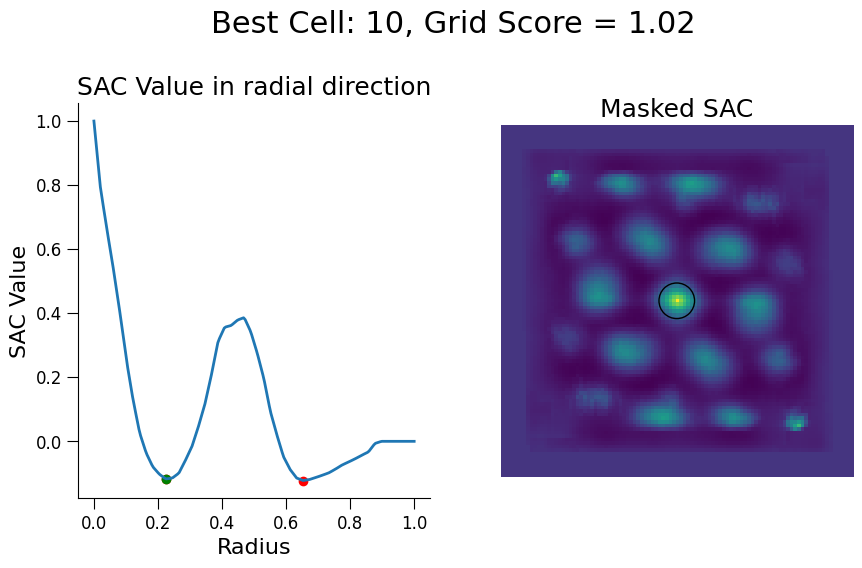

In [108]:
width = get_cell_width(10, plot=True)
plt.savefig(fig_directory + '/field-width-method-cell-10.png')
plt.savefig(fig_directory + '/field-width-method-cell-10.svg')

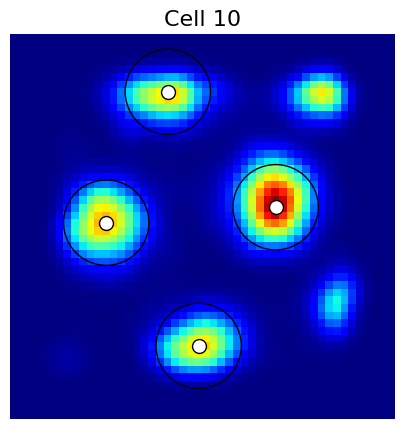

In [107]:
show_width_of_field(10)
plt.savefig(fig_directory + '/field-width-cell-10.png')
plt.savefig(fig_directory + '/field-width-cell-10.svg')

In [74]:
def get_accepted_cells(cell_trial_dict):
    
    accepted = []
    
    for cell in cell_trial_dict:
        none_trials = 0
        for trial in cell_trial_dict[cell]:
            if cell_trial_dict[cell][trial]['spacing_odd'] is None:
                none_trials += 1
            elif cell_trial_dict[cell][trial]['spacing_even'] is None:
                none_trials += 1
                
        if none_trials <= 5:
            accepted.append(cell)
    
    return accepted

In [75]:
def get_delta_mean_differences(cell_trial_dict):
    
    accepted = get_accepted_cells(cell_trial_dict)
    
    delta_spacing_between_mean = []
    width = []

    for cell in accepted:
        
        cell_width = get_cell_width(int(cell))
        delta_spacing_between = []
        
        for trial in cell_trial_dict[cell]:
            
            if (cell_trial_dict[cell][trial]['spacing_odd'] is not None) and (cell_trial_dict[cell][trial]['spacing_even'] is not None):
                second_cell = random.choice(list(accepted))
                while (cell_trial_dict[second_cell][trial]['spacing_odd'] is None) or (cell_trial_dict[second_cell][trial]['spacing_even'] is None):
                    second_cell = random.choice(list(accepted))

                delta_spacing_between.append(abs(cell_trial_dict[cell][trial]['spacing_even'] - cell_trial_dict[second_cell][trial]['spacing_odd']))
            
        delta_spacing_between_mean.append(np.mean(delta_spacing_between))
        width.append(cell_width)
    
    # convert all four variables to arrays
    delta_spacing_between_mean = np.array(delta_spacing_between_mean)
    
    return delta_spacing_between_mean, width

# Scatter plot of between vs field width

In [119]:
# plt.scatter(grid_score_session, delta_orientation_within_sessions, color = 'lightgrey', s= 30, edgecolor='grey')
# multiply every value of width by a hundred
rats = ['q', 'q', 'r1', 'r1', 'r1', 's', 'r2', 'r2']
mods = ['1', '2', '1', '2', '3', '1', '1', '2']
colors = ['skyblue', 'lightcoral', 'lightgreen', 'orange', 'pink', 'yellow', 'purple', 'brown', 'black']
i = 0
r_squared = []
p_values = []

for rat, mod in zip(rats, mods): 
    color = colors[i]
    i += 1
    G, general_results_working_directory, session_results_directory = load_grid_metrics_from_pickle(rat, mod)
    
    with open(general_results_working_directory + '/' + rat + mod + '/' + rat + mod + '_odds-even-30s-no-rejection.json') as f:
        cell_trial_dict = json.load(f)
    
    delta_spacing, width = get_delta_mean_differences(cell_trial_dict)
    width_cm = np.array(width) * 100
    accepted_cells = get_accepted_cells(cell_trial_dict)

    spacing = []
    for cell in accepted_cells:
        spacing.append(G.spacing[int(cell)])
    
    fig, ax = plt.subplots(1, 2, figsize = (14, 5))
    
    # add title to the figure as rat and module
    fig.suptitle('Rat ' + rat + ' Module ' + mod, fontsize = 18)
    ax[0].scatter(width_cm + np.random.normal(0, 0.8, len(width_cm)), delta_spacing, color = color, s= 30, edgecolor='grey')
    slope, intercept, r_value, p_value, std_err = linregress(np.array(width_cm), delta_spacing)
    r_squared.append(r_value**2)
    p_values.append(p_value)
    ax[0].plot(np.array(width_cm), np.array(width_cm) * slope + intercept, color = 'lightgrey', linewidth = 2)
    ax[0].set_xlabel('Field Width (cm)', fontsize = 16)
    ax[0].set_ylabel(r'$\overline{\Delta\lambda}_{between}$ (cm)', fontsize = 16)
    ax[0].set_title('Field Width vs Variability', fontsize = 16)
    # have a legend showing the slope and r square
    ax[0].text(0.6, 0.9, 'p-value = {:.2f}'.format(p_value), transform=ax[0].transAxes, fontsize=14, backgroundcolor = 'white')
    ax[0].text(0.6, 0.8, r'$r^2$ = {:.2f}'.format(r_value**2), transform=ax[0].transAxes, fontsize=14, backgroundcolor = 'white')
    
    ax[1].scatter(width_cm + np.random.normal(0, 0.8, len(width_cm)), spacing, color = color, s= 30, edgecolor='grey')
    slope, intercept, r_value, p_value, std_err = linregress(np.array(width_cm), spacing)
    ax[1].plot(np.array(width_cm), np.array(width_cm) * slope + intercept, color = 'lightgrey', linewidth = 2)
    ax[1].set_xlabel('Field Width (cm)', fontsize = 16)
    ax[1].set_ylabel('Spacing (cm)', fontsize = 16)
    ax[1].set_title('Field Width vs Spacing', fontsize = 16)
    # have a legend showing the slope and r square
    ax[1].text(0.1, 0.9, 'p-value = {:.2f}'.format(p_value), transform=ax[1].transAxes, fontsize=14)
    ax[1].text(0.1, 0.8, r'$r^2$ = {:.2f}'.format(r_value**2), transform=ax[1].transAxes, fontsize=14)
    
    # remove splines
    for axx in ax:
        axx.spines['top'].set_visible(False)
        axx.spines['right'].set_visible(False)
        axx.tick_params(axis='both', which='major', labelsize=12)
        
    plt.tight_layout()
    # plt.savefig(fig_directory + '/rat-' + rat + '-mod-' + mod + '.png')
    # # save as svg too
    # plt.savefig(fig_directory + '/rat-' + rat + '-mod-' + mod + '.svg')
    plt.close()
    

Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\q1 already exists


C:\Users\acostamendoza\projects\Grid-orientation-project\src\GridMetrics.py:226: RuntimeWarning: invalid value encountered in divide
  x_coef = np.divide(covar, np.multiply(std_seq1, std_seq2))


Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\q2 already exists
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r11 already exists
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r12 already exists
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r13 already exists
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\s1 already exists
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r21 already exists
Directory C:\Users\acostamendoza\projects\Grid-orientation-project\results\r22 already exists


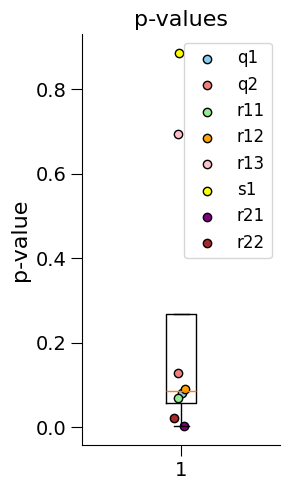

In [121]:
# Create a boxplot with the r squared values
fig, ax = plt.subplots(1, 1, figsize=(3, 5))
ax.boxplot(r_squared, showfliers=False)

# Add scatter points with jitter
for rvalue in r_squared:
    jittered_x = 1 + np.random.normal(0, 0.02)  # Add jitter to the x-coordinate
    ax.scatter(jittered_x, rvalue, color=colors[r_squared.index(rvalue)], edgecolor='black', label=rats[r_squared.index(rvalue)] + mods[r_squared.index(rvalue)])

ax.set_ylabel(r'$r^2$', fontsize=16)
ax.set_title(r'$r^2$ values', fontsize=16)
# add legend to colors and which session is it
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()

plt.savefig(fig_directory + '/r-squared-values.png')
plt.savefig(fig_directory + '/r-squared-values.svg')
plt.close()

fig, ax = plt.subplots(1, 1, figsize=(3, 5))
ax.boxplot(p_values, showfliers=False)

# Add scatter points with jitter
for pvalue in p_values:
    jittered_x = 1 + np.random.normal(0, 0.02)  # Add jitter to the x-coordinate
    ax.scatter(jittered_x, pvalue, color=colors[p_values.index(pvalue)], edgecolor='black', label=rats[p_values.index(pvalue)] + mods[p_values.index(pvalue)])
    
ax.set_ylabel('p-value', fontsize=16)
ax.set_title('p-values', fontsize=16)
# add legend to colors and which session is it
ax.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)

plt.tight_layout()


# # add the scatter points
# for rvalue in r_squared:
#     ax.scatter(1 + np.random.normal(1, 0.05, 1), rvalue, color = colors[r_squared.index(rvalue)])
